In [3]:
import simulator as sm
import os
import numpy as np
from datetime import date 
import matplotlib.pyplot as plt
import astropy.units as U
from casatasks import exportfits, simobserve, tclean
times = [4.27 * 60, 1.85 * 60, 4.88 * 50, 5.15 * 60,  5.15 * 60, 3.47 * 60, 14.25 * 60]
crop = False
flatten = True
cycle = 3
antenna_config = 4
band = 3
n_pxs = 256
main_path = '/home/michele/GitHub/ALMASim'
data_dir = '/home/michele/casa-data'
project = 'sims'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
output_dir = os.path.join(data_dir, "spatially_bounded")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plot_dir = os.path.join(output_dir, "plots")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
cycle_name = 'cycle{}'.format(int(cycle))
antenna_name = 'alma.cycle{}.0.{}'.format(cycle, antenna_config)
antennalist = os.path.join(main_path, "antenna_config", cycle_name, antenna_name + '.cfg')
spatial_resolution = sm.get_spatial_resolution(band, antenna_config)
print('Spatial Resolution:', spatial_resolution)
central_freq= sm.get_band_central_freq(band)
print('Central Frequency: ', central_freq)
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist)
central_freq = sm.get_band_central_freq(band)
beam_size = sm.compute_beam_size_from_max_baseline(max_baseline, central_freq)
fov = sm.get_fov([band])[0]
cell_size = beam_size / 5
print(max_baseline, beam_size)
n_px = int(fov / cell_size)
n_px = 256
bandwidth = 1000
inwidth = 10
fwhm_x = 10 * cell_size * np.random.rand() + cell_size
fwhm_y = 10 * cell_size  * np.random.rand() + cell_size
fwhm_z = 0.1 * bandwidth * np.random.rand() + inwidth
print('FWHM X:', fwhm_x)
print('FWHM Y:', fwhm_y)
print('FWHM Z:', fwhm_z)
n_channels = int(bandwidth / inwidth)
print('Number of Channels:', n_channels)
i = 0
n_sources = 0
ra, dec = 0, 0
pa = 128
min_sep_spatial = 0
min_sep_frequency = 0
rest_frequency = 1440.4
serendipitous = False
filename = sm.generate_pointlike_skymodel(i, output_dir, rest_frequency, 
                                                   inwidth * U.MHz, fwhm_z * U.MHz,
                                                   central_freq * U.GHz, n_px, 
                                                   n_channels, ra * U.deg, dec * U.deg,
                                                   spatial_resolution * U.arcsec, plot_dir)

totaltime = 1.85 * 60
simobserve(
    skymodel=filename,
    project=project,
    indirection="J2000 19h30m00 -40d00m00",
    incell="{}arcsec".format(cell_size),
    incenter='{}GHz'.format(central_freq),
    inwidth="{}MHz".format(inwidth),
    inbright="0.001Jy/pixel",
    setpointings=True,
    obsmode='int',
    antennalist=antennalist,
    totaltime="{}s".format(totaltime),
    integration="{0}s".format(totaltime),
    graphics='none',
    overwrite=True,
    thermalnoise="tsys-atm",
)
tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[n_px, n_px],
    cell="{}arcsec".format(cell_size),
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2,
)
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "clean_cube_" + str(i) +".fits"), overwrite=True)
clean, clean_header = sm.load_fits(os.path.join(output_dir, "clean_cube_" + str(i) +".fits"))
dirty, dirty_header = sm.load_fits(os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"))
print('Cropping and Saving Plots')
if crop == True:
    left = int((clean.shape[-1] - n_pxs) / 2)
    clean_cube = clean[:, :,  left:left+int(n_pxs), left:left+int(n_pxs)]
    dirty_cube = dirty[:, :, left:left+int(n_pxs), left:left+int(n_pxs)]
    if flatten == True:
        clean_cube = np.expand_dims(np.sum(clean_cube, axis=1), axis=1)
        dirty_cube = np.expand_dims(np.sum(dirty_cube, axis=1), axis=1)
        
    sm.write_numpy_to_fits(clean_cube, clean_header, os.path.join(output_dir, "clean_cube_" + str(i) +".fits"))
    sm.write_numpy_to_fits(dirty_cube, dirty_header, os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"))
sm.plotter(i, output_dir, plot_dir)

Spatial Resolution: 0.92
Central Frequency:  100
2.4291621329582047 0.3128650779165905
FWHM X: 0.5290666106017324
FWHM Y: 0.37160581264608195
FWHM Z: 46.543203443548535
Number of Channels: 100
Generating point-like source at position (127, 127, 50)
Skymodel saved to /home/michele/casa-data/spatially_bounded/skymodel_0.fits


KeyboardInterrupt: 

(100, 256, 256)


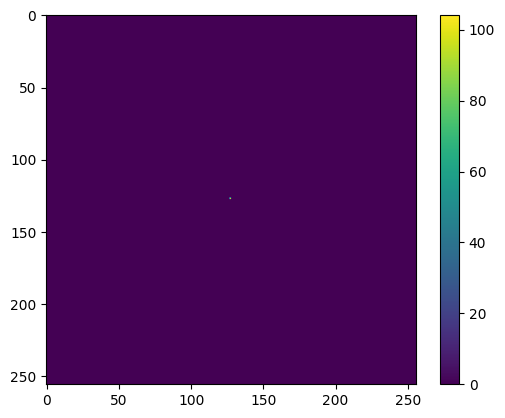

In [7]:
import simulator as sm
import os
import numpy as np
from datetime import date 
import matplotlib.pyplot as plt
import astropy.units as U
from casatasks import exportfits, simobserve, tclean
i = 0
data_dir = '/home/michele/casa-data'
output_dir = os.path.join(data_dir, "spatially_bounded")
data, header = sm.load_fits(os.path.join(output_dir, "skymodel_" + str(i) +".fits"))
print(data.shape)
image = np.sum(data, axis=0)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.show()

In [4]:
import simulator as sm
import simulator as sm

cycle = 3
antenna_config = 4
band = 3
antennalist = "/home/michele/GitHub/ALMASim/antenna_config/cycle{}/alma.cycle{}.0.{}.cfg".format(cycle, cycle, antenna_config) 
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist)
central_freq = sm.get_band_central_freq(band)
beam_size = sm.compute_beam_size_from_max_baseline(max_baseline, central_freq)
fov = sm.get_fov([band])[0]
cell_size = beam_size / 5
print(max_baseline, beam_size)
n_px = int(fov / cell_size)
print('Central Frequency: ', central_freq)
print('Beam Size (arcsec):', beam_size)
print('Field of View (arcsec):', fov)
print('Cell Size (arcsec): ', cell_size)
print('Number of Pixels:', n_px)


2.4291621329582047 0.3128650779165905
Central Frequency:  100
Beam Size (arcsec): 0.3128650779165905
Field of View (arcsec): 62.867243742793704
Cell Size (arcsec):  0.0625730155833181
Number of Pixels: 1004
